# RNN VAE
<br>

<font color='#2c3e50'>
    
In this exercise, we will extend our Seq2Seq AE to Variational Autoencoder. As discussed in lectures, we will only use an approximation of ELBO loss: `mean square error` for the first term and `KL divergence` between normal distribution and distribution of hidden vectors $\mathbf{z}$.  
    
<br>
    
Apart ftom loss function, RNN VAE differs from Seq2Seq AE in only one way: In VAE, Encoder outputs a `distribution of hidden representation` (instead of a single vector as in Seq2Seq AE). One vector is randomly sampled from this distribution and is given as input to decoder. This process is referred to as `Reparameterisation Trick`. The decoder intialises its hidden state with this vector. The rest of functionality remains same.        
</font>
             
## 1. Task:
<font color='red'>

<b>You need to partially implement reparameterisation trick:</b> 
</font>

<font color='#2c3e50'>
<ul>
<li>

Modify `RNN_Autoencoder` class from the previous exercise.</li>
    
<li>
     
Complete `forward()` function of `RNN_Autoencoder` class. </li>
    
<li> 
    
You need to map the hidden representation given by encoder to mean and standard deviation of a distribution using linear layers. You can add new layers or functions to `RNN_Autoencoder` class. </li> 
 

<li> 

The rest of the steps are already implemented. This mean and deviation are used for sampling a hidden state by `sample_standard_gaussian()`.</li> 

    
<li> 

Analyse the performance and compare against the previous models</li>
    
<li>
    
Analyse the mean and standard deviation of latent z distribution before and after training </li>
    
</ul>    
</font>



## 2. Hint:

<br>
<font color='#2c3e50'> 
Implement a fully connected network (of multiple layers (your choice)) that takes a $D$ dimenional hidden vector as input and generates a $2\times D$ dimenional vector. Consider first $D$ elements of this output vector as mean and remaining as standard deviation.
    
`Don't forget to use the Tanh activation between the hidden layers`. 

    
 You can analyse `sample_standard_gaussian()` in `utils.py`for more clues.     
</font>


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
from utils import get_validation_score_VAE,split_last_dim,sample_standard_gaussian
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim,device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNNCell(input_dim, hidden_dim)
        self.device=device
    
    def forward(self, x):
        hidden = self.init_hidden(x)
        time_steps=x.shape[1]  #shape of x is (batches,time_Steps,features)
        
        
        for i in range(0,time_steps):
            inputs=x[:,i] # (batch,features) shape
            hidden = self.rnn(inputs,hidden)        
        #### return hidden states obtained after final time-step
        return hidden
    
    def init_hidden(self, x):
        h0 = torch.zeros(x.size(0), self.hidden_dim)
        return h0.to(self.device)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, linear_latent_dim,device):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.rnn = nn.RNNCell(input_dim, hidden_dim)
        self.linear_layers=nn.Sequential(nn.Linear(hidden_dim, linear_latent_dim),nn.Tanh(),nn.Linear(linear_latent_dim, input_dim),)
        self.device=device
        
    
    def forward(self, x,states):
        hidden = states
        time_steps=x.shape[1]  #shape of x is (batches,time_Steps,features)
        
        all_hidden=[]
        
        for i in range(0,time_steps):
            inputs=x[:,i] # (batch,features) shape
            hidden = self.rnn(inputs,hidden)
            all_hidden.append(hidden)
        #### return hidden states obtained after final time-step
        all_hidden=torch.stack(all_hidden) # (time_steps,batches,hidden_dim)
        
        all_hidden=all_hidden.transpose_(1,0)  #(batches,time_steps,hidden_dim)
        
        out=self.linear_layers(all_hidden)    # (batches,time_steps,hidden_dim)
        return out
    


In [ ]:
class RNN_Autoencoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, decoder_linear_dim,device):
        super().__init__()
        
        self.encoder=Encoder(input_dim,hidden_dim,device)  
        ###########################################
        # Write you code here: Define a layer or multiple layers for mapping z to mean and std 
        #
        #
        #        
        ###############################
        self.decoder=Decoder(input_dim,hidden_dim,decoder_linear_dim,device)
        self.fc = nn.Linear(hidden_dim, 1)
        self.activation = nn.Sigmoid()
        self.device=device
    
    
    def forward(self,x):
        states=self.encoder(x)
        
        #############################
        #write your code here
        #
        #
        #
        #
        #  output of these lines of codes should be z0_mean and z0_std
        ###################################
         
        z0_sample = sample_standard_gaussian(z0_mean, z0_std,self.device)
        
        recon=self.decoder(x,z0_sample)
        pred=self.fc(states) 
        return recon, self.activation(pred),z0_mean,z0_std


In [ ]:
    def kl_divergence(mu, std):
        kl_loss = -0.5 * (1 + std - torch.square(mu) - torch.exp(std))
        kl_loss=torch.mean(torch.sum(kl_loss,dim=1))
        return kl_loss

In [ ]:
def trainer(model,training_set,validation_set,device,lr,store_name,epochs=10):
    ##### Recieve data and labels 
    T,L=training_set 
    Val_T,Val_L=validation_set
    
    ###### intialise optimiser and criterion
    
    optimizer_model = torch.optim.SGD(model.parameters(),lr,momentum=0.9, nesterov=True)
    
    criterion1 = nn.BCELoss().to(device)
    criterion2 = nn.MSELoss().to(device)


    best=0
    a=0.5
    b=0.5
    
    LOSS=[]                 # we are only interetsed in analysing BCE loss
    VAL_LOSS=[]
    
    
    for epoch in range(0,epochs):
        model.train()
        ELBO=0
        BC=0
        Total_loss=0
        for k in tqdm(range(0,len(T))):
            
            inputs=T[k]
            labels=L[k]
            
            inputs=torch.Tensor(inputs).to(device)
            labels=torch.Tensor(labels).type(torch.FloatTensor).to(device)
            
            recon,pred,mu,std=model(inputs)
            
            kl = kl_divergence(mu, std)
            mse=criterion2(recon,inputs)
            
            Elbo=(kl+mse) # Approximation of -ELBO
            
            loss1=criterion1(pred[:,0],labels)
        
            loss=a*loss1+b*Elbo
            
            optimizer_model.zero_grad()
            loss.backward()
            optimizer_model.step()
            
            ELBO=ELBO+Elbo
            BC=BC+loss1
            
            Total_loss=Total_loss+loss
             
        Val_ROC,val_loss=get_validation_score_VAE(model,Val_T,Val_L)
        LOSS.append((BC/len(T)).detach().cpu().numpy())
        VAL_LOSS.append(val_loss.detach().cpu().numpy())
        
        print(' Epoch: {:.1f} ElBO {:.4f} BCE_Loss {:.4f} Total_Loss {:.4f} Validation_AUC {:.4f}'.format(epoch,(ELBO/len(T)),(BC/len(T)),(Total_loss/len(T)), Val_ROC))
        if best<Val_ROC:
           torch.save(model, './'+store_name) 

    return torch.load('./'+store_name).to(device),LOSS, VAL_LOSS 

In [ ]:
from get_data import get_training_data,get_validation_data
T,L=get_training_data(batch_size=32) # returns lists of training data and label batches
Val_T,Val_L=get_validation_data() # numpy arrays of validation data and labels
print(T[0].shape) # (batch_size,time_steps,n_features)

(33, 48, 59)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
n_features=T[0].shape[2] # 59 dimensional vector at each time step
recurrent_units=128 # number of recurrent hidden units in encoder and decoder RNN Cells  
latent_linear_units=32 # units in linear layers in Decoder. This layer maps hidden states at each time-step to input space in reconstruction.
lr=0.001

model=RNN_Autoencoder(n_features,recurrent_units,latent_linear_units,device)
print(model)

RNN_Autoencoder(
  (encoder): Encoder(
    (rnn): RNNCell(59, 128)
  )
  (z0_net): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): Tanh()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (decoder): Decoder(
    (rnn): RNNCell(59, 128)
    (linear_layers): Sequential(
      (0): Linear(in_features=128, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=59, bias=True)
    )
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (activation): Sigmoid()
)


In [ ]:
model=model.to(device)
model, training_loss, validation_loss=trainer(model,(T,L),(Val_T,Val_L),device,lr,store_name='RNN_VAE',epochs=10)

100%|██████████| 201/201 [00:08<00:00, 22.70it/s]


 Epoch: 0.0 ElBO 0.7359 BCE_Loss 0.5185 Total_Loss 0.6272 Validation_AUC 0.7192


100%|██████████| 201/201 [00:08<00:00, 23.12it/s]


 Epoch: 1.0 ElBO 0.5373 BCE_Loss 0.4187 Total_Loss 0.4780 Validation_AUC 0.7657


100%|██████████| 201/201 [00:08<00:00, 23.79it/s]


 Epoch: 2.0 ElBO 0.4853 BCE_Loss 0.4004 Total_Loss 0.4429 Validation_AUC 0.7895


100%|██████████| 201/201 [00:08<00:00, 23.44it/s]


 Epoch: 3.0 ElBO 0.4497 BCE_Loss 0.3814 Total_Loss 0.4156 Validation_AUC 0.7997


100%|██████████| 201/201 [00:08<00:00, 23.07it/s]


 Epoch: 4.0 ElBO 0.4201 BCE_Loss 0.3641 Total_Loss 0.3921 Validation_AUC 0.8047


100%|██████████| 201/201 [00:08<00:00, 23.77it/s]


 Epoch: 5.0 ElBO 0.3942 BCE_Loss 0.3546 Total_Loss 0.3744 Validation_AUC 0.8070


100%|██████████| 201/201 [00:08<00:00, 22.76it/s]


 Epoch: 6.0 ElBO 0.3733 BCE_Loss 0.3517 Total_Loss 0.3625 Validation_AUC 0.8081


100%|██████████| 201/201 [00:08<00:00, 23.02it/s]


 Epoch: 7.0 ElBO 0.3579 BCE_Loss 0.3506 Total_Loss 0.3543 Validation_AUC 0.8088


100%|██████████| 201/201 [00:08<00:00, 23.07it/s]


 Epoch: 8.0 ElBO 0.3467 BCE_Loss 0.3499 Total_Loss 0.3483 Validation_AUC 0.8092


100%|██████████| 201/201 [00:08<00:00, 22.84it/s]


 Epoch: 9.0 ElBO 0.3385 BCE_Loss 0.3492 Total_Loss 0.3438 Validation_AUC 0.8097


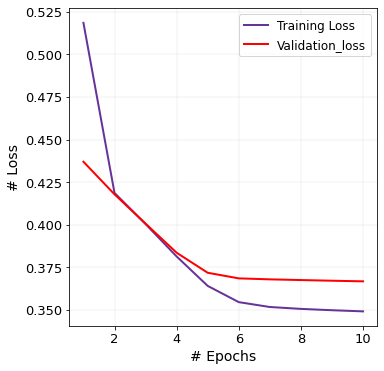

In [ ]:
# Plot training and validation loss
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,5))

lw = 2

plt.tight_layout()
ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),training_loss, color='rebeccapurple',
         lw=2, linestyle='-', label='Training Loss')

ax.plot(np.linspace(1, len(training_loss), num=len(training_loss)),validation_loss, color='r',
         lw=2, linestyle='-', label='Validation_loss')

ax.set_xlabel('# Epochs',fontsize=14)
ax.set_ylabel('# Loss',fontsize=14)
ax.legend(loc="best",fontsize=12)

ax.tick_params(axis='x', labelsize=13)
ax.tick_params(axis='y', labelsize=13)


plt.grid(color='gray', linestyle='-', linewidth=0.1)


plt.show()